In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from datasets import load_dataset

dataset = load_dataset("OsBaran/try")


split_dataset = dataset['train'].train_test_split(test_size=0.5, seed=42)

train_data = split_dataset['train']
test_data = split_dataset['test']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/358 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78588 [00:00<?, ? examples/s]

In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_texts = train_data['text']
train_labels = train_data['label']
test_texts = test_data['text']
test_labels = test_data['label']

train_texts = [clean_text(text) for text in train_texts]
test_texts = [clean_text(text) for text in test_texts]
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

y_train = train_labels
y_test = test_labels


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

param_dist = {
    'C': np.logspace(-3, 3, 7),  # 10^-3'ten 10^3'e kadar
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000],
    'tol': [1e-4, 1e-3, 1e-2]
}

lr = LogisticRegression()

random_search = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")


Best Parameters: {'tol': 0.01, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10.0}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression(max_iter=100,tol=0.01,solver="liblinear", penalty="l1", C=10.0);
lr_model.fit(X_train, train_labels)

y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.94


In [ ]:
# from sklearn.metrics import confusion_matrix
# import numpy as np

# # Örnek gerçek değerler (y_test)
# y_test = np.array([1, 0, 0, 1, 0, 1, 0, 1, 1, 0])

# # Örnek tahminler (y_pred)
# y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0])

# # Confusion matrix hesapla
# cm = confusion_matrix(y_test, y_pred)

# print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[3 2]
 [2 3]]


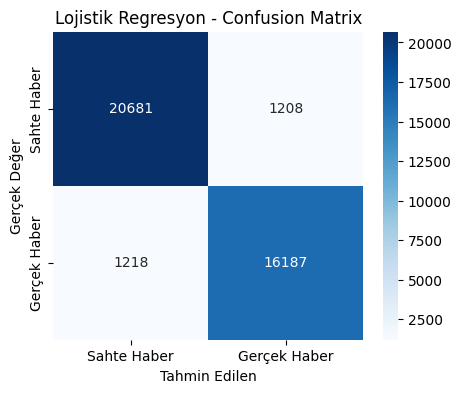

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sahte Haber", "Gerçek Haber"], yticklabels=["Sahte Haber", "Gerçek Haber"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Lojistik Regresyon - Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     21889
           1       0.93      0.93      0.93     17405

    accuracy                           0.94     39294
   macro avg       0.94      0.94      0.94     39294
weighted avg       0.94      0.94      0.94     39294



In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.train(params, dtrain, num_boost_round=100)

y_pred_proba = model.predict(dtest)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_proba]

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.92


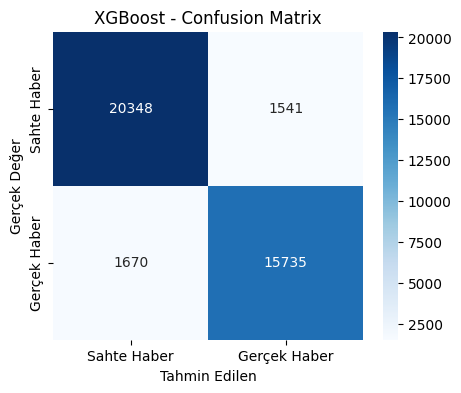

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sahte Haber", "Gerçek Haber"], yticklabels=["Sahte Haber", "Gerçek Haber"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("XGBoost - Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93     21889
           1       0.91      0.91      0.91     17405

    accuracy                           0.92     39294
   macro avg       0.92      0.92      0.92     39294
weighted avg       0.92      0.92      0.92     39294



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train, train_labels)

y_pred = nb_model.predict(X_test)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.86


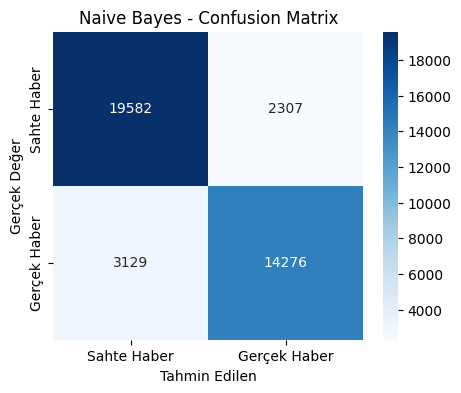

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sahte Haber", "Gerçek Haber"], yticklabels=["Sahte Haber", "Gerçek Haber"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Naive Bayes - Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.89      0.88     21889
           1       0.86      0.82      0.84     17405

    accuracy                           0.86     39294
   macro avg       0.86      0.86      0.86     39294
weighted avg       0.86      0.86      0.86     39294



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=1, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=30, min_samples_split=2, min_samples_leaf=2)

rf_model.fit(X_train, train_labels)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")



Test Accuracy: 0.92


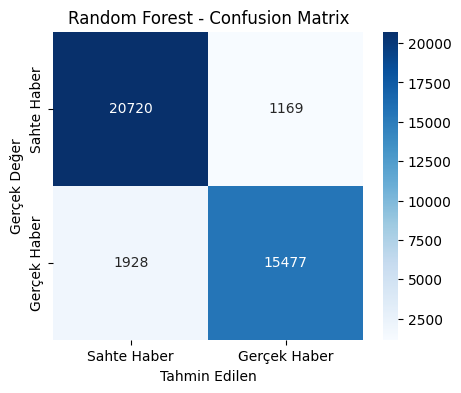

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sahte Haber", "Gerçek Haber"], yticklabels=["Sahte Haber", "Gerçek Haber"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Random Forest - Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.95      0.93     21889
           1       0.93      0.89      0.91     17405

    accuracy                           0.92     39294
   macro avg       0.92      0.92      0.92     39294
weighted avg       0.92      0.92      0.92     39294



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.datasets import load_iris

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = RandomizedSearchCV(SVC(), param_grid, cv=5, n_iter=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

y_pred = grid_search.best_estimator_.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = LinearSVC(random_state=42, C=1.0,tol=0.001, penalty="l1", loss="squared_hinge")

svm_model.fit(X_train, train_labels)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.94


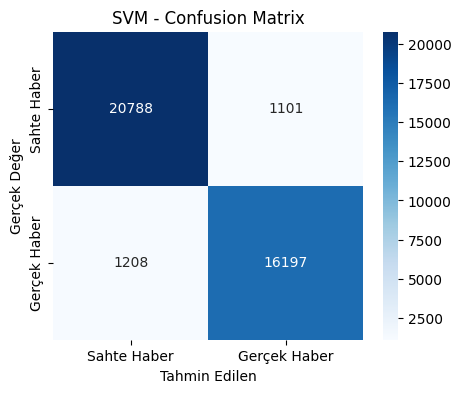

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sahte Haber", "Gerçek Haber"], yticklabels=["Sahte Haber", "Gerçek Haber"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("SVM - Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     21889
           1       0.94      0.93      0.93     17405

    accuracy                           0.94     39294
   macro avg       0.94      0.94      0.94     39294
weighted avg       0.94      0.94      0.94     39294



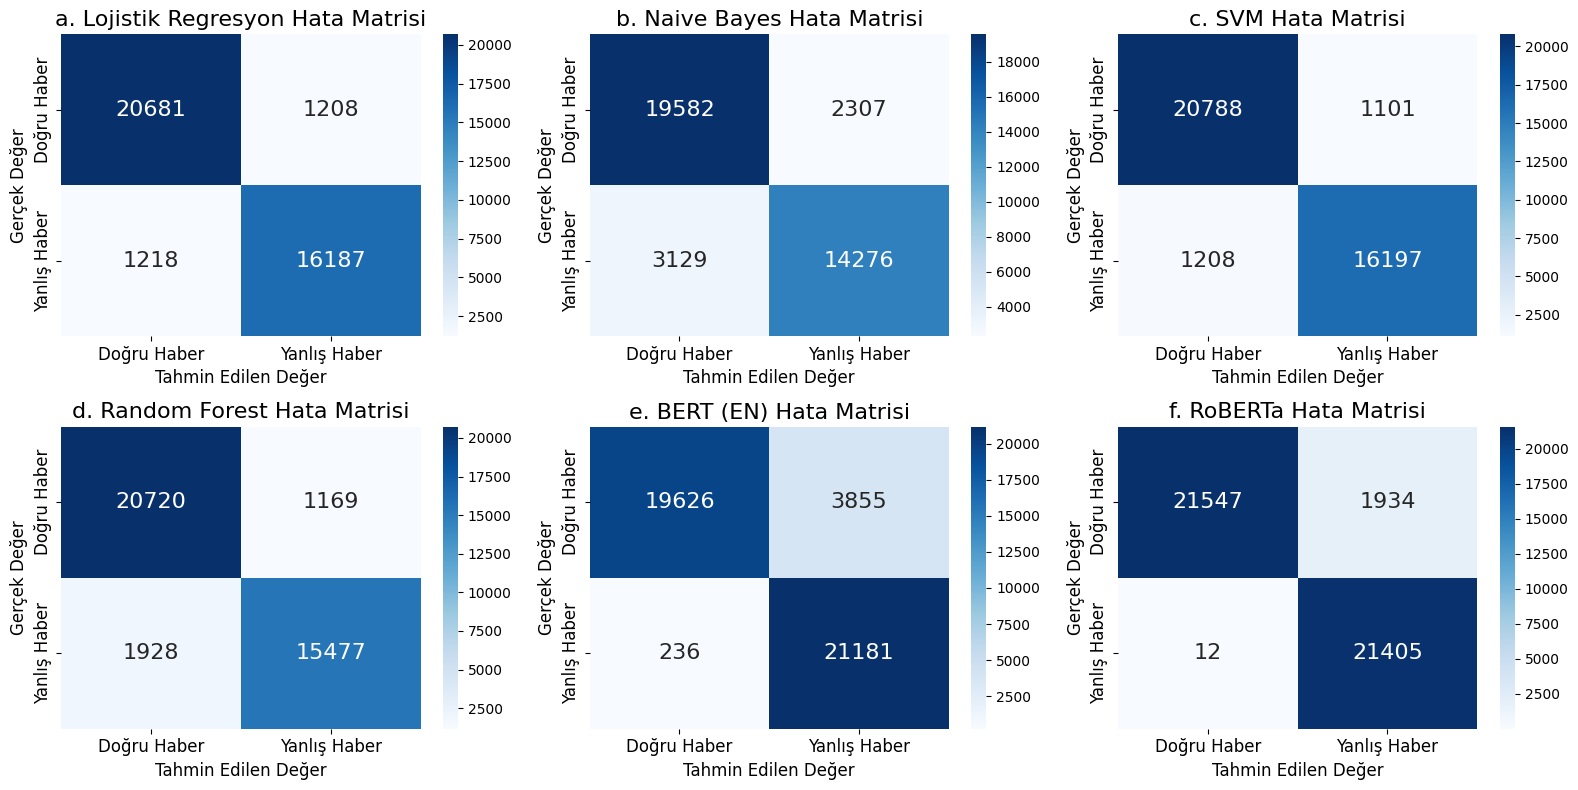

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


matrisler = [
    np.array([[20681, 1208], [1218, 16187]]),
    np.array([[19582, 2307], [3129, 14276]]),
    np.array([[20788, 1101], [1208, 16197]]),
    np.array([[20720, 1169], [1928, 15477]]),
    np.array([[19626, 3855], [236, 21181]]),
    np.array([[21547, 1934], [12, 21405]]),
]


basliklar = [
    "a. Lojistik Regresyon Hata Matrisi",
    "b. Naive Bayes Hata Matrisi",
    "c. SVM Hata Matrisi",
    "d. Random Forest Hata Matrisi",
    "e. BERT (EN) Hata Matrisi",
    "f. RoBERTa Hata Matrisi",
]



fig, axes = plt.subplots(2, 3, figsize=(16, 8),facecolor='white')  # 2 satır, 4 sütun
axes = axes.flatten()

for i, (ax, matris) in enumerate(zip(axes, matrisler)):
    sns.heatmap(
        matris,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=True,
        ax=ax,
        annot_kws={"size": 16},
    )
    ax.set_title(basliklar[i],fontsize=16)
    ax.set_xlabel("Tahmin Edilen Değer",fontsize=12)
    ax.set_ylabel("Gerçek Değer",fontsize=12)
    ax.set_xticklabels(["Doğru Haber", "Yanlış Haber"],fontsize=12)
    ax.set_yticklabels(["Doğru Haber", "Yanlış Haber"],fontsize=12)


for j in range(len(matrisler), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
